In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["font.family"] = "sans-serif"

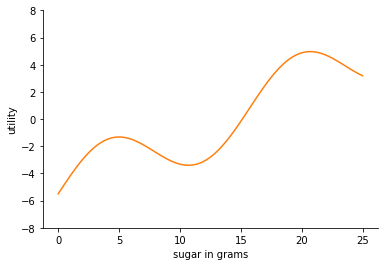

In [2]:
def f(x):
    return (np.sin(x / 2.5) * 6 + x) / 2.5 - 5.5


x_test = np.linspace(0, 25, 100).reshape(-1, 1)

plt.plot(x_test, f(x_test), c="C1", label="objective")

plt.ylim(-8, 8)
plt.xlabel("sugar in grams")
plt.ylabel("utility")
plt.show()

In [3]:
import torch
import gpytorch

import sys

sys.path.append("../")

from optimization.opt_utils import fit_model
from scipy.stats import norm

# the expected improvement policy

In [4]:
x_train = torch.tensor([[3], [12], [20], [4], [11]]).float()

comp_train = torch.tensor(
    [
        [0, 1],  # f(3) > f(12)
        [2, 0],  # f(3) < f(20)
        [2, 1],  # f(12) < f(20)
        [2, 3],
        [2, 4],
    ]
).long()

model = fit_model(
    x_train,
    comp_train,
    covar_module=gpytorch.kernels.RBFKernel(
        lengthscale_constraint=gpytorch.constraints.GreaterThan(2.5)
    ),
)

In [5]:
with torch.no_grad():
    output = model(torch.tensor(x_test))
    lower, upper = output.confidence_region()


star_ind = np.argmax(output.mean.numpy())
x_star = x_test[star_ind]
y_star = output.mean.numpy()[star_ind]
x_star, y_star

/Users/quannguyen/anaconda3/envs/preference_botorch/lib/python3.9/site-packages/botorch/models/pairwise_gp.py:283: RuntimeWarning: X is not a p.d. matrix; Added jitter of 1.00e-05 to the diagonal
  warnings.warn(


(array([19.94949495]), 0.88804567)

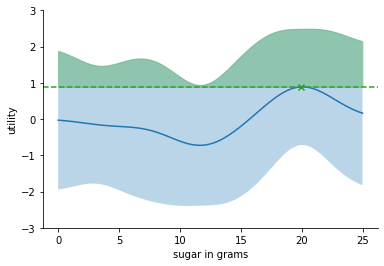

In [6]:
with torch.no_grad():
    output = model(torch.tensor(x_test))
    lower, upper = output.confidence_region()

plt.plot(x_test, output.mean, label="mean")
plt.fill_between(x_test.flatten(), lower, upper, alpha=0.3, label="CI")

star_ind = np.argmax(output.mean.numpy())
x_star = x_test[star_ind]
y_star = output.mean.numpy()[star_ind]

plt.scatter(x_star, y_star, c="C2", marker="x")
plt.axhline(y_star, c="C2", linestyle="--")

plt.fill_between(x_test.flatten(), upper, y_star, color="C2", alpha=0.3)

plt.xlabel("sugar in grams")
plt.ylabel("utility")
plt.ylim(-3, 3)

plt.show()

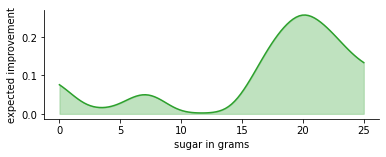

In [7]:
mu = output.mean.detach().numpy()
sigma = output.covariance_matrix.diag().detach().numpy()

improvements = mu - y_star
Z = improvements / sigma
ei = improvements * norm.cdf(Z) + sigma * norm.pdf(Z)

plt.figure(figsize=(6, 2))

plt.plot(x_test, ei, c="C2")
plt.fill_between(x_test.flatten(), ei, 0, color="C2", alpha=0.3)

plt.xlabel("sugar in grams")
plt.ylabel("expected improvement")

plt.show()

# the optimization loop

In [8]:
from optimization.experiments import single_experiment
from policies.incumbent import IncumbentExpectedImprovement

In [68]:
def visualize_belief_and_ei(model, x_train, comp_train, f):
    with torch.no_grad():
        output = model(torch.tensor(x_test))
        lower, upper = output.confidence_region()

    plt.plot(x_test, output.mean, label="mean")
    plt.fill_between(x_test.flatten(), lower, upper, alpha=0.3, label="CI")

    plt.xlabel("sugar in grams")
    plt.ylabel("utility")
    plt.ylim(-3, 3)

    plt.show()

    print()

    mu = output.mean.detach().numpy()
    sigma = output.covariance_matrix.diag().detach().numpy()

    improvements = mu - y_star
    Z = improvements / sigma
    ei = improvements * norm.cdf(Z) + sigma * norm.pdf(Z)

    plt.figure(figsize=(6, 2))

    plt.plot(x_test, ei, c="C2")
    plt.fill_between(x_test.flatten(), ei, 0, color="C2", alpha=0.3)

    plt.axvline(x_test[np.argmax(ei)], linestyle="--", c="C3")  # candidate
    plt.axvline(x_test[torch.argmax(output.mean)], linestyle="--", c="C2")  # incumbent

    plt.xlabel("sugar in grams")
    plt.ylabel("expected improvement")

    plt.show()

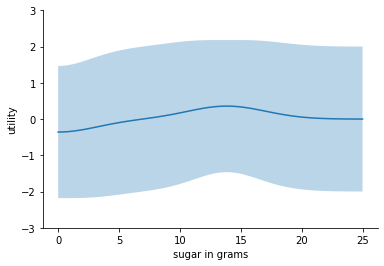

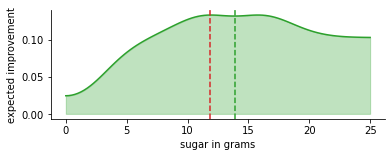

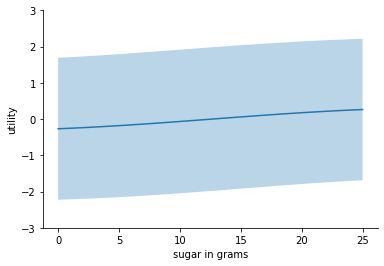

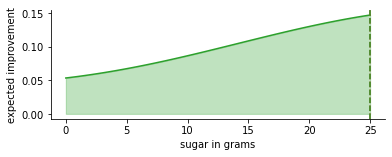

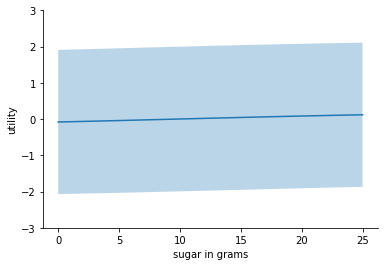

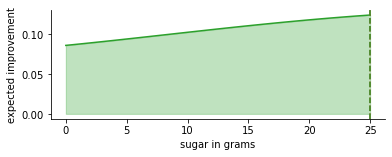

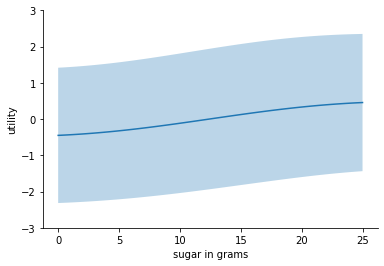

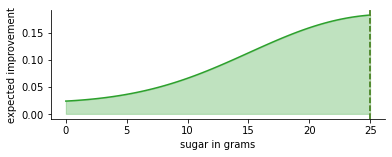

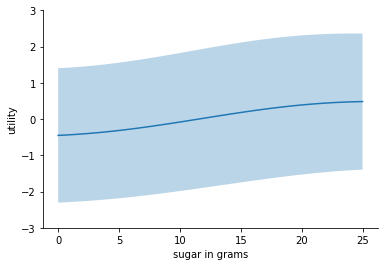

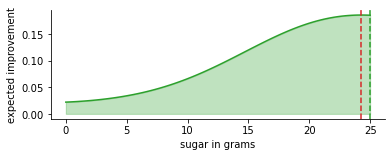

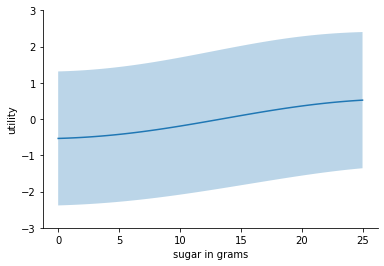

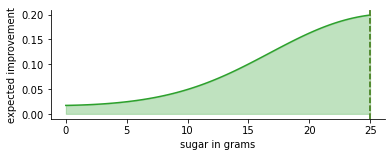

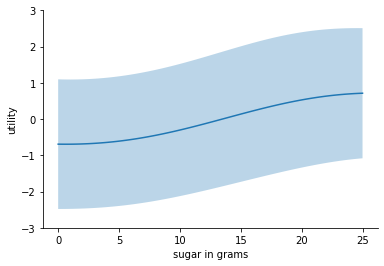

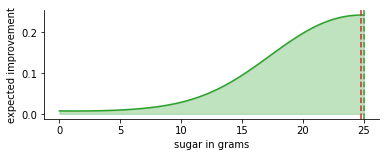

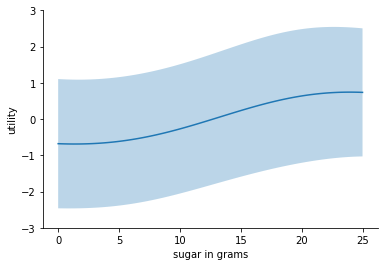

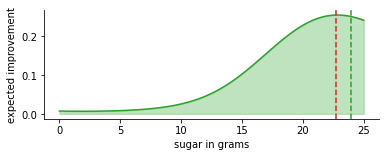

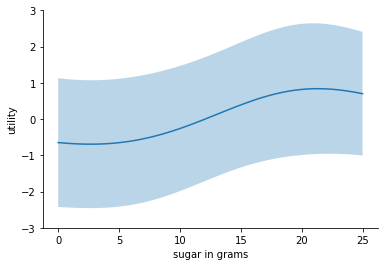

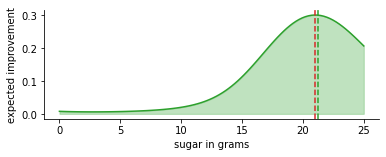

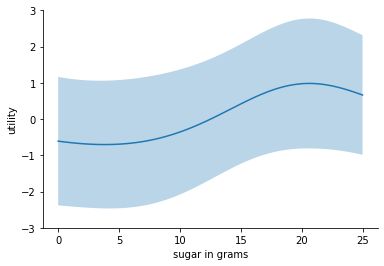

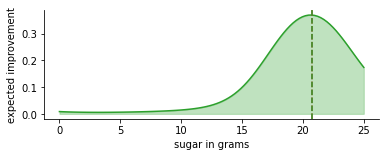

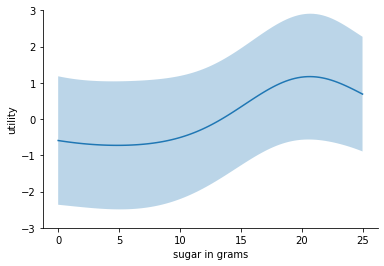

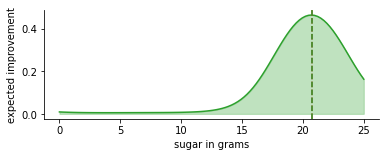

In [72]:
bounds = torch.stack([torch.zeros(1), 25 * torch.ones(1)])

ei = IncumbentExpectedImprovement(bounds, n_restarts=10, n_raw_samples=10)
covar_module = gpytorch.kernels.RBFKernel(
    lengthscale_constraint=gpytorch.constraints.GreaterThan(2.5)
)

single_experiment(
    f,
    1,
    torch.tensor([20]).float(),
    bounds,
    ei,
    covar_module=covar_module,
    noise=0,
    budget=10,
    visualize_fn=visualize_belief_and_ei,
    seed=6,  # 1, 40
);